# Generalized additive models: A complete example with real data


In this lesson, we will use GAMs to analyze real data in R. In particular, we'll revisit our NYC cycling data to see how we might use GAMs as a better fitting model than the GLM used in an earlier lesson.


#### The bike data: revisited

The goal of the `bike` data is to keep count of cyclists entering and leaving Queens, Manhattan and Brooklyn via the East River Bridges. The Traffic Information Management System (TIMS) collected this count data for several months during 2017. Each record represents the total number of cyclists per 24 hours at Brooklyn Bridge, Manhattan Bridge, Williamsburg Bridge, and Queensboro Bridge. Also included in the dataset are date and temperature imformation.

Column Name	and Column Description

1. `date`: Date the count was conducted


2. `day`: Day of the week the count was conducted


3. `temp_h`: The high temperature for that day in fahrenheit


4. `temp_l`:	The low temperature for that night in fahrenheit


5. `precip`:	The amount of precipitation for that day in inches


6. ~~`bb`: Total number of cyclist counts at Brooklyn Bridge in a 24 hour period~~


7. `mb`: Total number of cyclist counts at Manhattan Bridge in a 24 hour period


8. ~~`wb`: Total number of cyclist counts at Williamburg Bridge in a 24 hour period~~


9. ~~`qb`:	Total number of cyclist counts at Queensboro Bridge in a 24 hour period~~


10. ~~`total`: The number of cyclist counts for all the East River Bridges combined in a 24 hour period~~

**Our goal will be to try to use the weather data to explain the total number of cyclists on the Manhattan Bridge on any given day.** We've done this already, using a Poisson regression GLM. The goal of this lesson will be to compare the fit of that GLM to a Poisson GAM!

(NEXT SLIDE)

In the accompaning notebook that you can follow along with, we'll load, clean, and prepare the data. For an explanation of these steps, see our lesson on *Poisson regression on real data in R*.

In [1]:
library(lubridate) #for the ymd() function
library(RCurl)
library(tidyverse)

#read in the data (paste0() allows for text wrapping)
urlfile = paste0("https://raw.githubusercontent.com/bzaharatos/",
                "-Statistical-Modeling-for-Data-Science-Applications/master/",
                 "Generalized%20Linear%20Models%20and%20Nonparametric%20Regression/",
                 "Datasets/2017%20Monthly%20Bike%20Count%20Totals%20for%20East%20River%20Bridges/bike.csv")
url = getURL(urlfile)
bike = read.csv(text = url, sep = ",", header = TRUE)

#check for NA
sum(is.na(bike$mb))
summary(bike)


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Loading required package: bitops
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::as.difftime() masks base::as.difftime()
✖ tidyr::complete()        masks RCurl::complete()
✖ lubridate::date()        masks base::date()
✖ dplyr::filter()          masks stats::filter()
✖ lubridate::intersect()   masks base::intersect()
✖ dplyr::lag()             masks stats::lag()
✖ lubridate::setdi

[1] 0

      date            day         temp_h         temp_l          precip   
 10/1   :  1   Friday   :30   Min.   :46.0   Min.   :37.00   0.00   :131  
 10/10  :  1   Monday   :31   1st Qu.:66.9   1st Qu.:55.23   T      : 14  
 10/11  :  1   Saturday :31   Median :75.9   Median :64.00   0.01   :  8  
 10/12  :  1   Sunday   :31   Mean   :74.2   Mean   :62.03   0.06   :  6  
 10/13  :  1   Thursday :30   3rd Qu.:82.0   3rd Qu.:70.00   0.02   :  4  
 10/14  :  1   Tuesday  :31   Max.   :93.9   Max.   :78.10   0.03   :  3  
 (Other):208   Wednesday:30                                  (Other): 48  
       bb             mb             wb             qb           total      
 Min.   : 151   Min.   : 484   Min.   : 874   Min.   : 865   Min.   : 2374  
 1st Qu.:2298   1st Qu.:4308   1st Qu.:5115   1st Qu.:3746   1st Qu.:15705  
 Median :2857   Median :5608   Median :6287   Median :4681   Median :19367  
 Mean   :2680   Mean   :5345   Mean   :6052   Mean   :4550   Mean   :18628  
 3rd Qu.:3285  

In [2]:
#replace T for 0...
bike = bike %>%
    mutate(precip = fct_recode(precip, "0" = "T"))
    #mutate(precip=replace(precip, precip== "T", NA))

#wrangle the data
bike = bike %>%
    mutate(temp_h = as.numeric(temp_h),temp_l = as.numeric(temp_l)) %>%
    mutate(mb = as.numeric(as.character(mb)),bb = as.numeric(as.character(bb)), 
           wb = as.numeric(as.character(wb)), qb = as.numeric(as.character(qb)),
           total = as.numeric(as.character(total))) %>%
    mutate(date = as.Date(as.character(date),format='%m/%d')) %>%
    mutate(precip = as.numeric(as.character(precip)))
           
#fix the year of the date variable
bike$date = ymd(as.character(bike$date)) - years(3)

Now, let's split the dataset into a training set and test set:

In [3]:
set.seed(8585)
bound = floor(nrow(bike)*0.8) #define % of training and test set

df = bike[sample(nrow(bike)), ]       #sample rows 
df_train = df[1:bound, ]              #get training set
df_test = df[(bound+1):nrow(bike), ]  #get test set

Later, we'll use the testing set for comparing the predictive power of our models. 

(NEXT SLIDE)

Let's first look at the relationship between the log of the total number of cyclist counts at Manhattan Bridge in a 24 hour period (`mb`) and the predictor variables low temp (`temp_l`), high temp (`temp_h`) and precipitation (`precip`). This relationship is interesting because, in Poisson regression, the link function assumes a linear  relationship between the log of the mean of the response (`mb`) and predictors:

\begin{align*}
\log(\mu_{mb}) = \beta_0 + \beta_1 \, \text{temp_l} + \beta_2 \, \text{temp_h} + \beta_3 \, \text{precip} 
\end{align*}

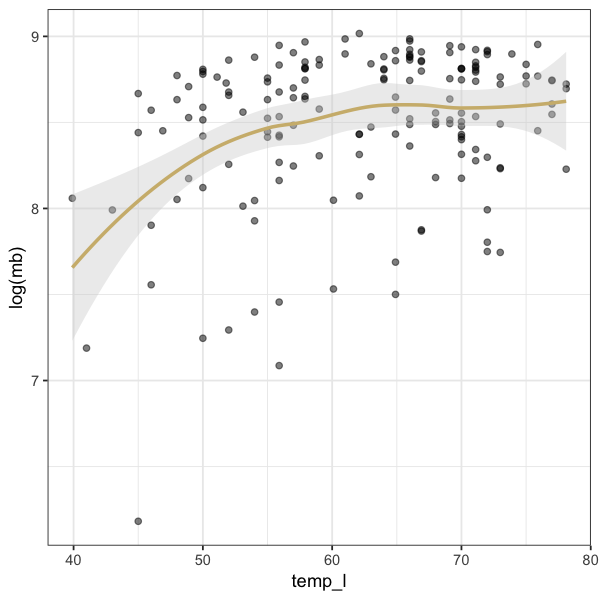

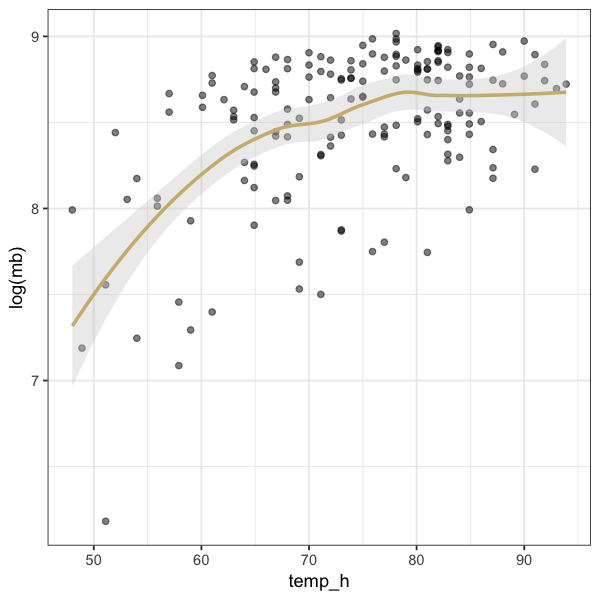

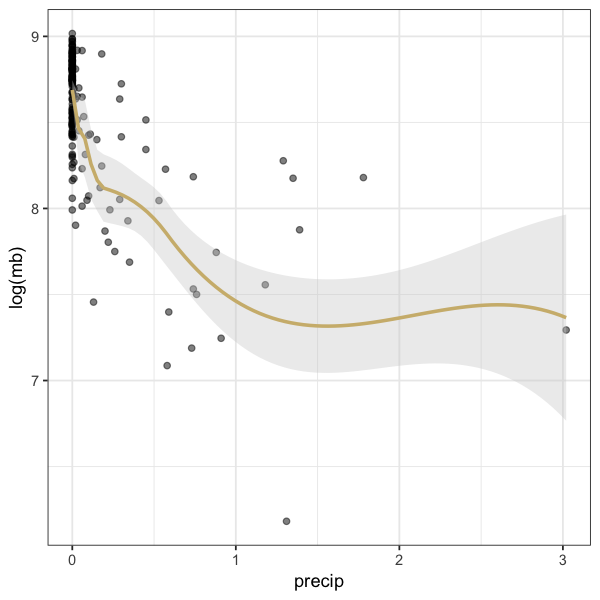

In [4]:
options(repr.plot.width = 5, repr.plot.height = 5)
library(ggplot2)

p1 = ggplot(df_train, aes(temp_l, log(mb))) +
    geom_point(alpha = 0.5) + 
    geom_smooth(method = "loess", formula = y ~ x, color = "#CFB87C", fill = "lightgrey") +
    theme_bw()
p1 #= p1 + ggsave("~/low-temp-count.pdf")

p2 = ggplot(df_train, aes(temp_h, log(mb))) +
    geom_point(alpha = 0.5) + 
    geom_smooth(method = "loess", formula = y ~ x, color = "#CFB87C", fill = "lightgrey") +
    theme_bw()

p2 #= p2 + ggsave("~/high-temp-count.pdf")

p3 = ggplot(df_train, aes(precip, log(mb))) +
    geom_point(alpha = 0.5) + 
    geom_smooth(method = "loess", formula = y ~ x, color = "#CFB87C", fill = "lightgrey") +
    theme_bw()

p3 #= p3 + ggsave("~/precip-temp-count.pdf")

We notice that the marginal relationships are not linear, especially the relationship between precipitation and the log of the count. This suggests that a standard GLM (which we fit in our discussion of Poisson regression) would be misspecified. Instead, let's fit a GAM, using the `mgcv` package and `gam()` function.

In [5]:
library(mgcv)
gam_bike = gam(mb ~ day + s(temp_l) + s(temp_h) + s(precip), data = df_train, family = poisson)
summary(gam_bike)

Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.



Family: poisson 
Link function: log 

Formula:
mb ~ day + s(temp_l) + s(temp_h) + s(precip)

Parametric coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   8.511736   0.003016 2822.31   <2e-16 ***
dayMonday     0.084812   0.004340   19.54   <2e-16 ***
daySaturday  -0.191308   0.004548  -42.06   <2e-16 ***
daySunday    -0.279671   0.004582  -61.03   <2e-16 ***
dayThursday   0.096838   0.004060   23.85   <2e-16 ***
dayTuesday    0.158348   0.004016   39.43   <2e-16 ***
dayWednesday  0.152038   0.004045   37.59   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
            edf Ref.df Chi.sq p-value    
s(temp_l) 8.550  8.937   1217  <2e-16 ***
s(temp_h) 8.887  8.995   5571  <2e-16 ***
s(precip) 8.936  8.998  25633  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.806   Deviance explained =   83%
UBRE = 109.55  Scale est. = 1         n = 171

Let's first interpret the smooth table. Importantly, we see high edfs for each of the smooth terms, providing some evidence that we should be smoothing these terms (as opposed to having them enter the model linearly). In addition, the marginal plots of each predictor, adjusting for all others reinforces this conclusion that the relationships are nonlinear:

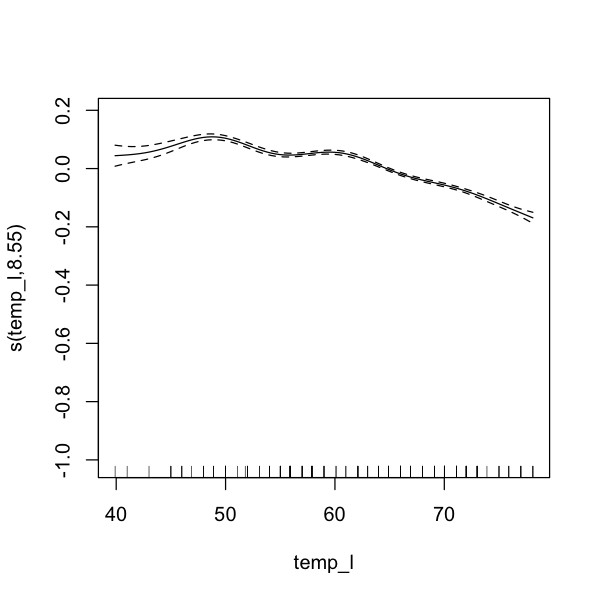

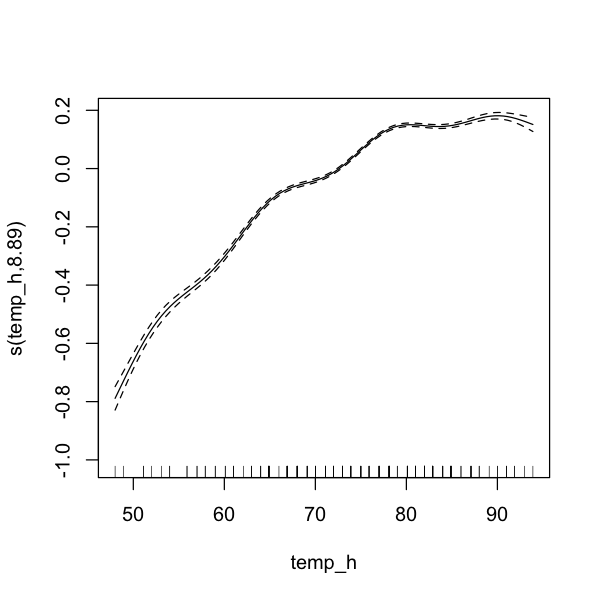

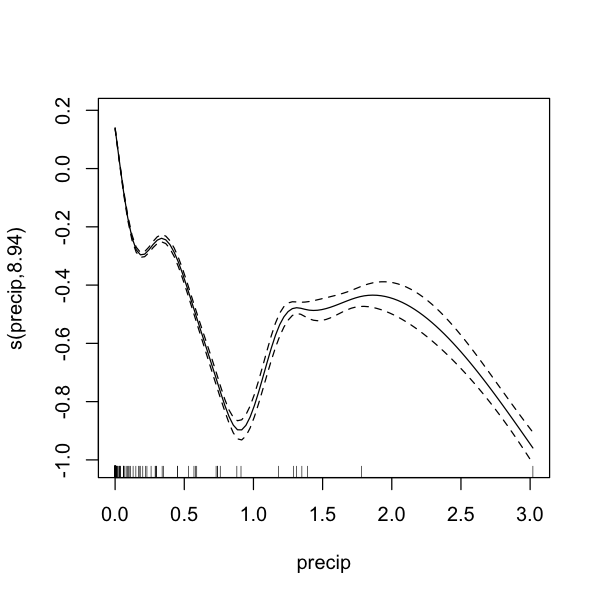

In [6]:
plot.gam(gam_bike)

We also see a significant day-of-week factor, suggesting that the day of week matters. Of particular interest might be how weekends compare to weekdays. The way our model is set up, the easiest comparison would be between Friday, the "baseline" in the model, and either Saturday or Sunday. We can see that (if the model is correct), on average, the total number of cyclists moving across the Manhattan Bridge is lower on both Saturday and Sunday than it is on Friday, adjusting for weather conditions (which are nonlinear adjustments). Further comparisons might be made using contrasts.

Further, we might be interested in interpreting how high tempterature impacts the total number of cyclists moving across the Manhattan Bridge. Consulting the marginal relationship plot above, we see that (if the model is correct), as the temperature increases from 50 degrees to 75 degrees, we see a sharp increase in `mb`, on average, adjusting for other predictors. after around 75 degrees, the relationship increases, but at a much gentler rate. This makes some intuitive sense: independent of low temperature, precipitation and day of week, cycling is more fun when it gets warm; but not too warm!

Now let's compare this GAM with the GLM fit in a previous lesson. We'll compare their performance, in terms of the (prediction) MSE, on the training and test set, the latter being more important since a high training MSE could be due to overfitting. First, we fit the Poisson GLM:

In [7]:
glm_bike = glm(mb ~ precip + temp_h + temp_l + day, data = df_train, family = poisson)
summary(glm_bike)
rsq = 1-34454/110729
cat("McFadden's R-squared is", rsq, ".")


Call:
glm(formula = mb ~ precip + temp_h + temp_l + day, family = poisson, 
    data = df_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-41.577   -7.122    2.309    8.523   38.973  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   7.7605007  0.0088089  880.98   <2e-16 ***
precip       -0.6733753  0.0049519 -135.98   <2e-16 ***
temp_h        0.0232326  0.0002333   99.59   <2e-16 ***
temp_l       -0.0139666  0.0002524  -55.34   <2e-16 ***
dayMonday     0.0758621  0.0038756   19.57   <2e-16 ***
daySaturday  -0.1993917  0.0042215  -47.23   <2e-16 ***
daySunday    -0.2618583  0.0043404  -60.33   <2e-16 ***
dayThursday   0.0999425  0.0038607   25.89   <2e-16 ***
dayTuesday    0.1419263  0.0038452   36.91   <2e-16 ***
dayWednesday  0.1580572  0.0038413   41.15   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 110729  on 17

McFadden's R-squared is 0.6888439 .

First MSE for training set:

In [8]:
p_glm = predict(glm_bike, type = "response"); 

mse_glm = mean((df_train$mb - p_glm)^2); #mse_glm

p_gam = predict(gam_bike, type = "response"); 

mse_gam = mean((df_train$mb - p_gam)^2); mse_glm  
mse_gam

hl = ifelse(mse_glm > mse_gam, "lower", "higher"); 
diff_train = mse_glm - mse_gam
cat("The GAM MSE for the training set is", hl, "than the MSE for the GLM on the training set. The difference is", diff_train, ".")

[1] 845631.3

[1] 475196

The GAM MSE for the training set is lower than the MSE for the GLM on the training set. The difference is 370435.3 .

And, for the MSE for test set:

In [9]:
p_glm_test = predict(glm_bike, newdata = df_test, type = "response");  

mse_glm_test = mean((df_test$mb - p_glm_test)^2); mse_glm_test

p_gam_test = predict(gam_bike, newdata = df_test, type = "response");  

mse_gam_test = mean((df_test$mb - p_gam_test)^2); mse_gam_test

hl = ifelse(mse_glm_test > mse_gam_test, "lower", "higher"); 
diff_test = mse_glm_test - mse_gam_test
cat("The GAM MSE for the test set is", hl, "than the MSE for the GLM on the test set. The difference is", diff_test, ".")

[1] 808855.4

[1] 662778.1

The GAM MSE for the test set is lower than the MSE for the GLM on the test set. The difference is 146077.3 .

AIC as model selection criterion:

[1] 0.7392466

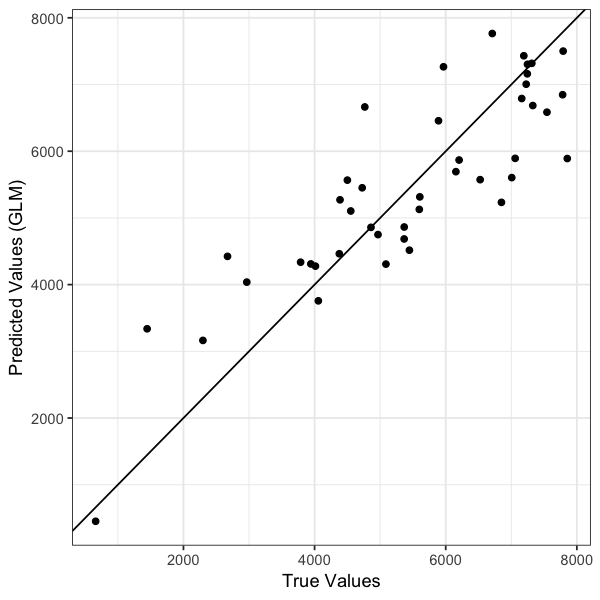

In [10]:
n_train = length(df_train$mb)
n_test = length(df_test$mb)

mu_test = predict(glm_bike, df_test, type="response")
y_test = df_test$mb

summary(lm(mu_test ~ y_test))$r.squared

options(repr.plot.width = 5, repr.plot.height = 5)
df_test_predict = data.frame(y_test, mu_test)
p = ggplot(df_test_predict) + geom_point(aes(y_test, mu_test))
p = p + geom_abline(intercept = 0, slope = 1)
p = p + theme_bw()
p = p + xlab("True Values") + ylab("Predicted Values (GLM)")
p

[1] 0.7861026

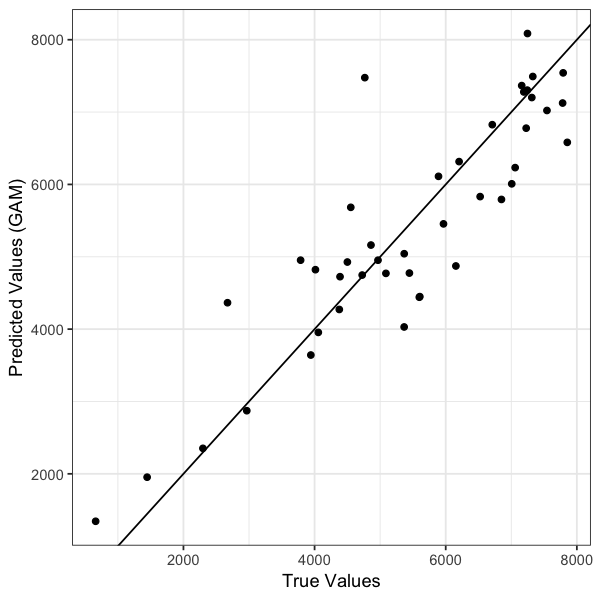

In [11]:
n_train = length(df_train$mb)
n_test = length(df_test$mb)

mu_test = predict(gam_bike, df_test, type="response")
y_test = df_test$mb
summary(lm(mu_test ~ y_test))$r.squared


options(repr.plot.width = 5, repr.plot.height = 5)
df_test_predict = data.frame(y_test, mu_test)
p = ggplot(df_test_predict) + geom_point(aes(y_test, mu_test))
p = p + geom_abline(intercept = 0, slope = 1)
p = p + theme_bw()
p = p + xlab("True Values") + ylab("Predicted Values (GAM)")
p